<a href="https://colab.research.google.com/github/Calabras/obrabotka_izobrajheniy/blob/main/DE_IP_2024_Task_3_Shilin_ND_3823B1PR1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [6]:
image = cv2.imread('sar_2.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

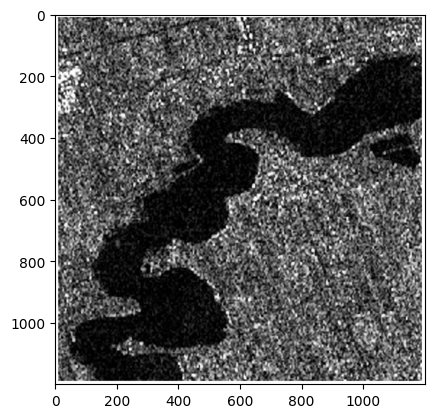

In [7]:
plt.imshow(image_gray, cmap="gray")

# Точечная бинаризация

In [8]:
import copy

bin_img = copy.deepcopy(image_gray)
T  = 50
bin_img[image_gray < T] = 0
bin_img[image_gray >= T] = 255

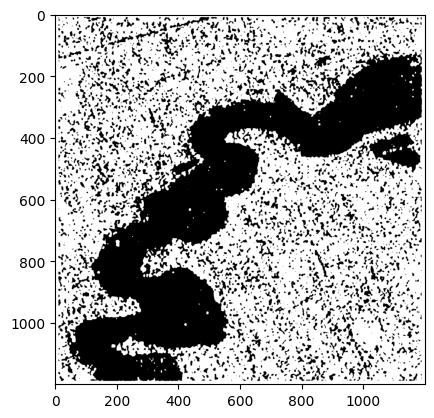

In [9]:
plt.imshow(bin_img, cmap="gray")

# Бинаризация Отсу

In [10]:
# otsu binarization
_,th2 = cv2.threshold(image_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

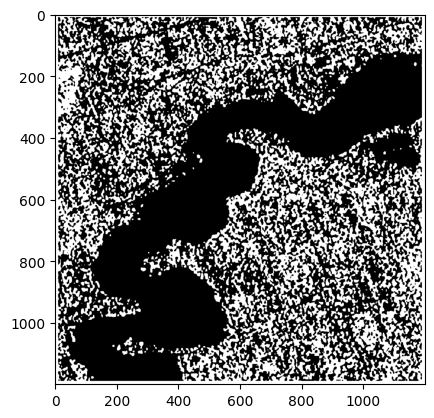

In [11]:
plt.imshow(th2, cmap="gray")

# Адаптивная бинаризация

In [12]:
#
th3 = cv2.adaptiveThreshold(image_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,71,21)


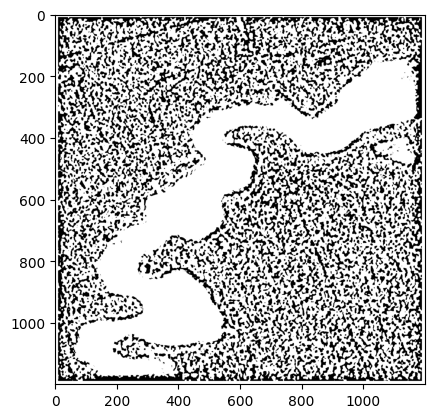

In [13]:
plt.imshow(th3, cmap="gray")

# Оператор Собеля

In [14]:
scale = 1
delta = 0
ddepth = cv2.CV_16S
grad_x = cv2.Sobel(image_gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
grad_y = cv2.Sobel(image_gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)

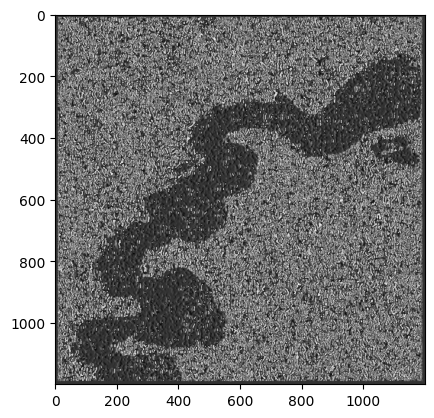

In [15]:
plt.imshow((grad_x - grad_x.min())*255, cmap="gray")

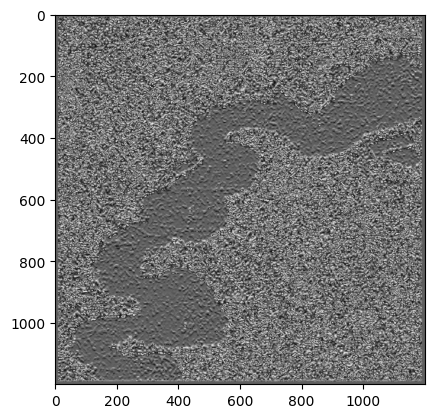

In [16]:
plt.imshow((grad_y - grad_y.min())*255, cmap="gray")

In [17]:
grad = cv2.addWeighted(grad_x, 0.5, grad_y, 0.5,0.0) # mean value between

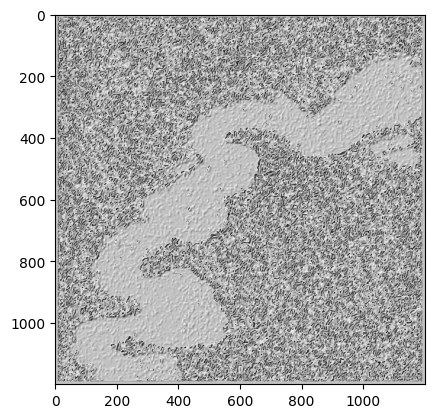

In [18]:
plt.imshow((grad - grad.min())*255, cmap="gray")

# Canny

In [19]:
edges = cv2.Canny(image_gray,100,200)

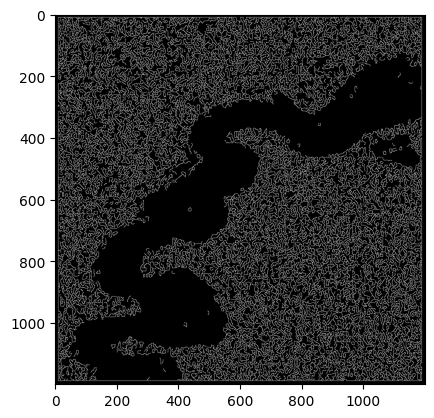

In [20]:
plt.imshow(edges, cmap="gray")

# Преобразование Хафа

In [21]:
image = cv2.imread('img_1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

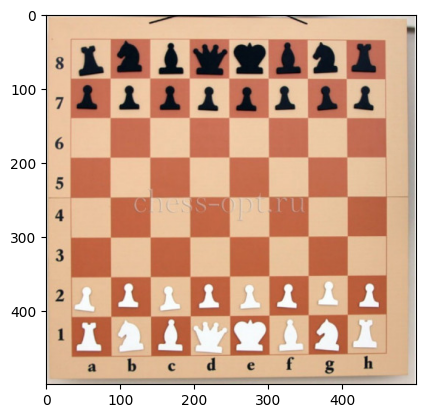

In [22]:
plt.imshow(image)

In [23]:
canny = cv2.Canny(image_gray,50,150,apertureSize = 3)

In [24]:
lines = cv2.HoughLines(canny, 1, np.pi / 180, 190)

In [25]:
import math

if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
            pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
            cv2.line(image, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)

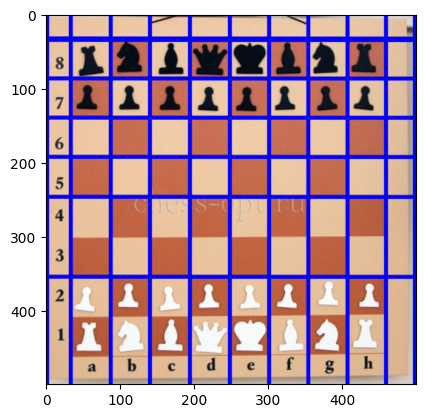

In [26]:
plt.imshow(image)

In [28]:
#ДЗ
# 1. Для изображения sar_3.jpg найти наиболее протяженный участок
# (выделить линии при помощи преобразования Хафа)
# 2. Для изображения sar_3.jpg провести исследование алгоритмов бинаризации, выделить участок дорожной полосы.

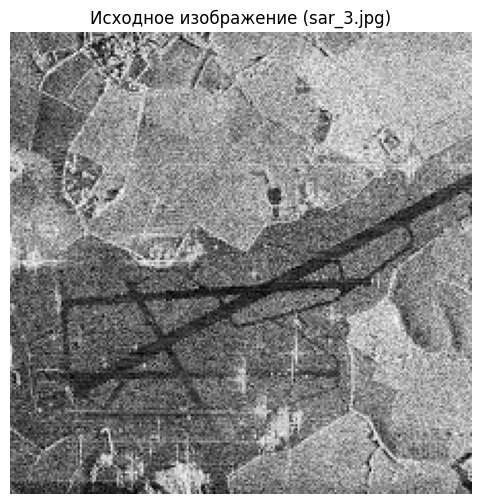

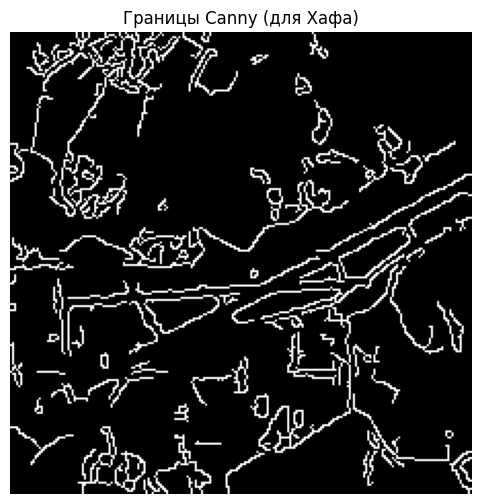

Найдено отрезков: 3
Самый длинный отрезок: (121,123)–(223,69), длина ≈ 115.4 пикс


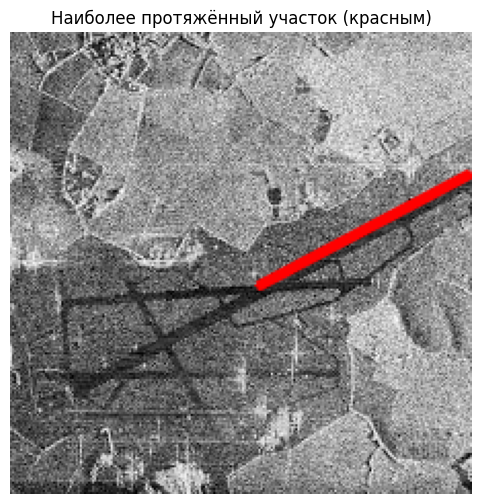

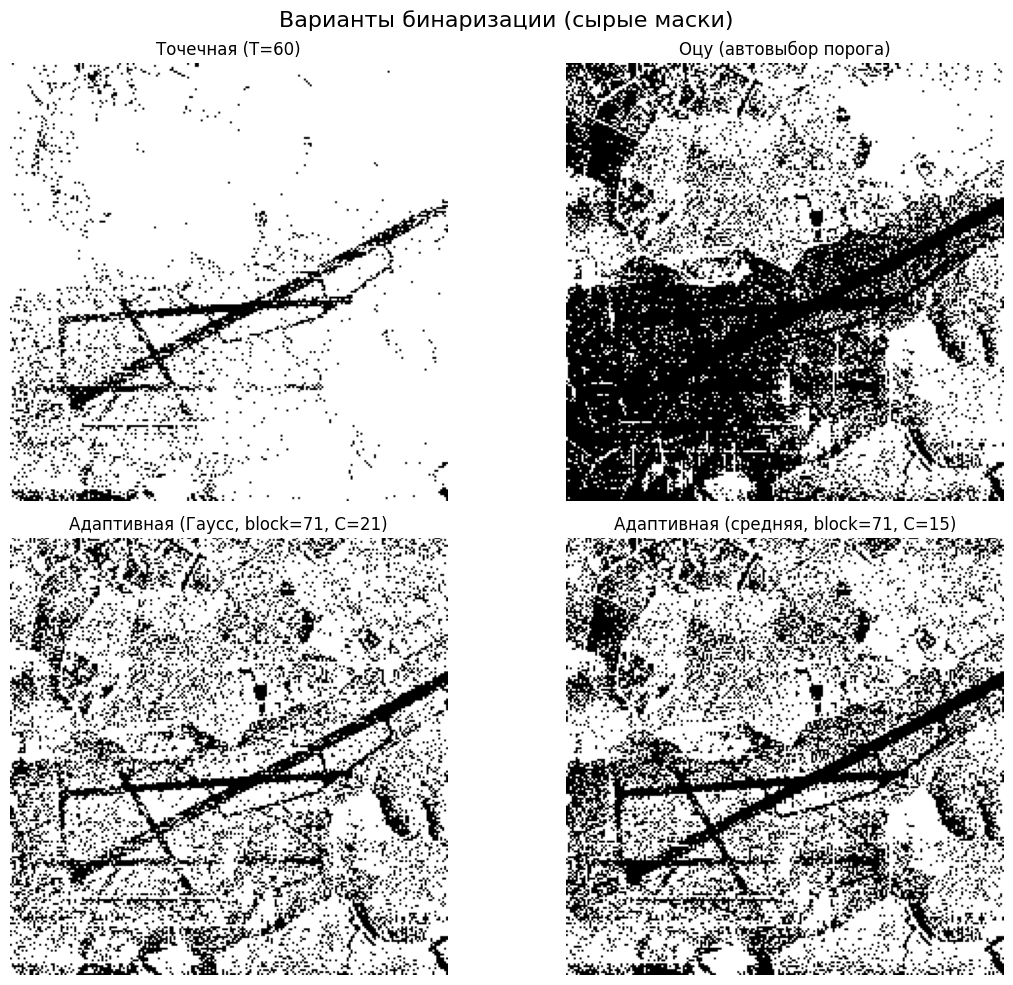

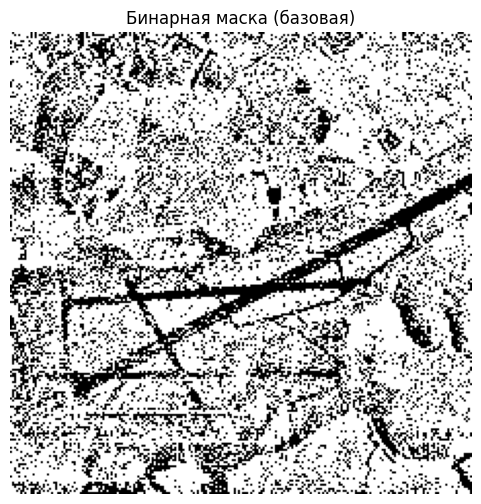

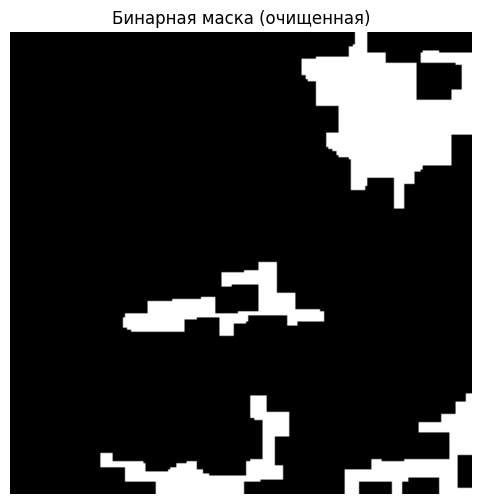

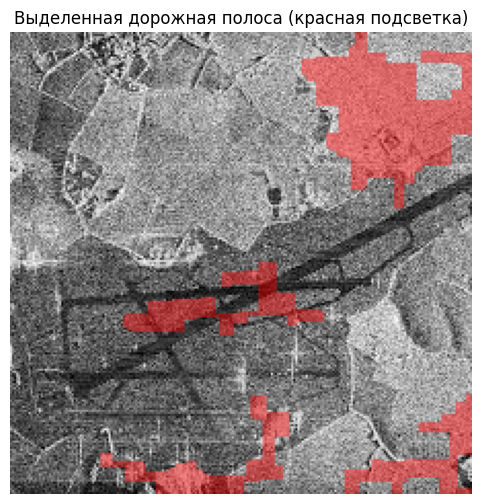

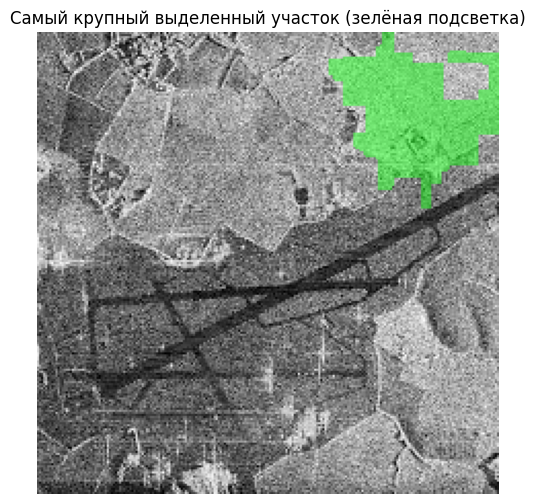

In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


#BGR-изображение (OpenCV) в корректных цветах RGB
def show_bgr(img_bgr, title='', size=(6, 6)):
    plt.figure(figsize=size)
    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()
#одноканальное изображение (градации серого)
def show_gray(img_gray, title='', size=(6, 6)):
    plt.figure(figsize=size)
    plt.imshow(img_gray, cmap='gray', vmin=0, vmax=255)
    plt.title(title)
    plt.axis('off')
    plt.show()
#еклидова длина отрезка между (x1,y1) и (x2,y2)
def segment_length(x1, y1, x2, y2):
    return float(np.hypot(x2 - x1, y2 - y1))

#поиск самой длинной линии (отрезок) с помощью Probabilistic Hough
def find_longest_line(
    gray,
    blur_ksize=5,
    canny_lo=80, canny_hi=160,
    hough_rho=1, hough_theta=np.pi/180,
    hough_thresh=80, min_line_len=80, max_line_gap=10
):
    if blur_ksize and blur_ksize >= 3:
        blurred = cv2.GaussianBlur(gray, (blur_ksize, blur_ksize), 0)
    else:
        blurred = gray

    #границы Canny
    edges = cv2.Canny(blurred, canny_lo, canny_hi, apertureSize=3, L2gradient=True)

    #преобразование Хафа (Probabilistic)
    linesP = cv2.HoughLinesP(
        edges,
        rho=hough_rho,
        theta=hough_theta,
        threshold=hough_thresh,
        minLineLength=min_line_len,
        maxLineGap=max_line_gap
    )

    best_segment = None
    best_len = 0.0

    if linesP is not None:
        for seg in linesP:
            x1, y1, x2, y2 = seg[0]
            L = segment_length(x1, y1, x2, y2)
            if L > best_len:
                best_len = L
                best_segment = (x1, y1, x2, y2)

    return edges, linesP, best_segment

def draw_segment(img_bgr, segment, color=(0, 0, 255), thickness=3):
    """нарисовать один отрезок на BGR-изображении"""
    out = img_bgr.copy()
    if segment is not None:
        x1, y1, x2, y2 = segment
        cv2.line(out, (x1, y1), (x2, y2), color, thickness, cv2.LINE_AA)
    return out

#набор бинарных масок для исследования
def binarization_variants(gray):
    masks = {}

    #точечная бинаризация
    T = 60
    _, fixed = cv2.threshold(gray, T, 255, cv2.THRESH_BINARY)
    masks[f'Точечная (T={T})'] = fixed

    #бинаризация Отсу
    _, otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    masks['Оцу (автовыбор порога)'] = otsu

    #адаптивная (Гаусс)
    ga = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,
        blockSize=71, C=21
    )
    masks['Адаптивная (Гаусс, block=71, C=21)'] = ga

    #адаптивная (средняя)
    me = cv2.adaptiveThreshold(
        gray, 255,
        cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,
        blockSize=71, C=15
    )
    masks['Адаптивная (средняя, block=71, C=15)'] = me

    return masks

#очистка бинарной маски
def clean_mask(mask, open_ks=5, close_ks=11, min_area=800):
    if mask.dtype != np.uint8:
        mask_u8 = (mask > 0).astype(np.uint8) * 255
    else:
        mask_u8 = np.where(mask > 0, 255, 0).astype(np.uint8)

    if open_ks and open_ks >= 3:
        kernel_o = cv2.getStructuringElement(cv2.MORPH_RECT, (open_ks, open_ks))
        mask_u8 = cv2.morphologyEx(mask_u8, cv2.MORPH_OPEN, kernel_o)

    if close_ks and close_ks >= 3:
        kernel_c = cv2.getStructuringElement(cv2.MORPH_RECT, (close_ks, close_ks))
        mask_u8 = cv2.morphologyEx(mask_u8, cv2.MORPH_CLOSE, kernel_c)

    cnts, _ = cv2.findContours(mask_u8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cleaned = np.zeros_like(mask_u8)
    for c in cnts:
        if cv2.contourArea(c) >= float(min_area):
            cv2.drawContours(cleaned, [c], -1, 255, thickness=cv2.FILLED)

    return cleaned

#наложить бинарную маску на изображение цветной полупрозрачной подсветкой
def overlay_mask(img_bgr, mask, color=(0, 0, 255), alpha=0.45):
    if mask.shape != img_bgr.shape[:2]:
        raise ValueError(f'Размеры маски {mask.shape} не совпадают с изображением {img_bgr.shape[:2]}')

    mask_bool = (mask > 0)
    color_img = np.full_like(img_bgr, color, dtype=np.uint8)
    blended = cv2.addWeighted(img_bgr, 1 - alpha, color_img, alpha, 0)
    out = img_bgr.copy()
    out[mask_bool] = blended[mask_bool]
    return out

image_path = 'sar_3.jpg'
img_bgr = cv2.imread(image_path)
if img_bgr is None:
    raise FileNotFoundError(f'Не удалось загрузить файл: {image_path}')
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

show_bgr(img_bgr, 'Исходное изображение (sar_3.jpg)')

#поиск самой длинной линии
edges, linesP, best_seg = find_longest_line(
    img_gray,
    blur_ksize=5,
    canny_lo=80, canny_hi=160,
    hough_rho=1, hough_theta=np.pi/180,
    hough_thresh=80,
    min_line_len=80,
    max_line_gap=10
)

show_gray(edges, 'Границы Canny (для Хафа)')

if linesP is None or len(linesP) == 0:
    print('Линии Хафа не найдены.')
else:
    print(f'Найдено отрезков: {len(linesP)}')
    if best_seg is not None:
        x1, y1, x2, y2 = best_seg
        L = segment_length(x1, y1, x2, y2)
        print(f'Самый длинный отрезок: ({x1},{y1})–({x2},{y2}), длина ≈ {L:.1f} пикс')
        img_with_longest = draw_segment(img_bgr, best_seg, color=(0, 0, 255), thickness=3)
        show_bgr(img_with_longest, 'Наиболее протяжённый участок (красным)')

#исследование бинаризации для выделения дорожной полосы
masks = binarization_variants(img_gray)

#показ «сырых» масок
plt.figure(figsize=(12, 10))
plt.suptitle('Варианты бинаризации (сырые маски)', fontsize=16)
for i, (name, m) in enumerate(masks.items(), start=1):
    plt.subplot(2, 2, i)
    plt.imshow(m, cmap='gray', vmin=0, vmax=255)
    plt.title(name)
    plt.axis('off')
plt.tight_layout()
plt.show()

#выбор базовой маски
base_mask = masks['Адаптивная (Гаусс, block=71, C=21)']

#очистка маски морфологией и фильтром площади
cleaned_mask = clean_mask(base_mask, open_ks=5, close_ks=11, min_area=800)

show_gray(base_mask, 'Бинарная маска (базовая)')
show_gray(cleaned_mask, 'Бинарная маска (очищенная)')

#наложение маски на исходник
overlay = overlay_mask(img_bgr, cleaned_mask, color=(0, 0, 255), alpha=0.45)
show_bgr(overlay, 'Выделенная дорожная полоса (красная подсветка)')

cnts, _ = cv2.findContours(cleaned_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
if cnts:
    largest = max(cnts, key=cv2.contourArea)
    only_largest = np.zeros_like(cleaned_mask)
    cv2.drawContours(only_largest, [largest], -1, 255, thickness=cv2.FILLED)
    overlay_largest = overlay_mask(img_bgr, only_largest, color=(0, 255, 0), alpha=0.45)
    show_bgr(overlay_largest, 'Самый крупный выделенный участок (зелёная подсветка)')
